# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
% matplotlib inline
from scipy.stats import norm
import datetime as dt
from datetime import date
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn import svm
from sklearn.model_selection import cross_val_score


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Some of the questions that we will try to answer: 

Q1. What is the average age of males and females in the customer profile?

Q2. What is the average income and how does it differs in males and females? 

Q3. Gender wise income distribution 

Q4. Gender wise age distribution

Q5. What percent of customers enrolled in an year?

Q6. What is the distribuion of male and female per year in the membership program?

Q7. what are the different types of offers?

Q8. How does customers responds(event) to different typesof offers?

Q9.How male and female respond to any offer? 

Q10. Build a machine learning model ro oredict response of customers to an offer.

# A. look into all the three datasets individually

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}



The offers ids are labelled as 'offer_id' in transcript data but as 'id' in portfolio data. While the ids of customers  are labelled as 'person' (in transcript data) and 'id' (in profile dataset).

Renaming ids columns in various datasets for better readability & easiness in merging dataframes later. : 
1. Ids of custmers will be renamed as 'customer_id'
2. Ids of offers will be renamed as 'offer_id'

In [6]:
#Renaming id column in portfolio as offer_id:
portfolio = portfolio.rename(columns={'id': 'offer_id'})
#Renaming id column in 'profile' as customer_id:
profile = profile.rename(columns={'id': 'customer_id'})
#Renaming 'person' column in transcript as customer_id:
transcript = transcript.rename(columns={'person': 'customer_id'})

# Profile dataset

In [7]:
#Profile dataest:
print('1. There are {} rows and {} columns in the customer profile dataset.'.format(profile.shape[0],profile.shape[1]))
print('2. The number of unique customers on starbucks app: {}.'.format(profile.customer_id.nunique()))

1. There are 17000 rows and 5 columns in the customer profile dataset.
2. The number of unique customers on starbucks app: 17000.


In [8]:
# A look at the missing values: There are 2175 missing values in 'gender' and 'income' columns.
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
customer_id            0
income              2175
dtype: int64

In [9]:
# age== 118 , an age of 118 doesnot look natural:
age_118_count = profile[profile['age']== 118].age.count()
age_118 = profile[profile.age == 118][['gender','age','income']]
print(age_118.head())
print('Count of customers with age== 118 is {}.'.format(age_118_count))

  gender  age  income
0   None  118     NaN
2   None  118     NaN
4   None  118     NaN
6   None  118     NaN
7   None  118     NaN
Count of customers with age== 118 is 2175.


#Thus it is clear age== 118 corresponds to missing values 2175 of 'gender' and 'income' columns and we will remove these rows from the profile dataframe (0.13% of data).

In [10]:

# take a look at the gender types: thereis a gender type '0', as it corresponds to only 212 instances we will drop it later.
profile.groupby(['gender']).count()

,age,became_member_on,customer_id,income
gender,,,,
F,6129,6129,6129,6129
M,8484,8484,8484,8484
O,212,212,212,212


In [11]:
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    df = profile.copy()
    
    #replace the age = 118 to age = nan, so that it can be removed later.
    df['age'] = df['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    df.dropna(inplace=True)
    

    #drop gender == 'O' from the gender column:
    df = df.drop(df[(df["gender"] == 'O')].index)
    
    # profile: create readable date format for became_member_on column.
    df.became_member_on = pd.to_datetime(df['became_member_on'], format = "%Y%m%d")
    
    
    # the number of days since the user is a memeber of starbucks
    df['memberdays'] = dt.datetime.today().date() - pd.to_datetime(df['became_member_on'], format='%Y%m%d').dt.date
    df['memberdays'] = df['memberdays'].dt.days
    
    
    # profile: add start_year column
    df['start_year'] = df.became_member_on.dt.year
    
    # profile: add start_month column
    df['start_month'] = df.became_member_on.dt.month
    
    #duplicate customer_id column:
    #df['c_mapping'] = df['customer_id']
    
    #process the duplicated customer_id column(to one hot encode the customer id ansd call it c_mapping)
    #cusids = df['c_mapping'].unique().tolist()
    #c_mapping = dict( zip(cusids,range(len(cusids))) )
    #df.replace({'c_mapping': c_mapping},inplace=True)
    
    # drop 'became_member_on':
    df.drop(columns = ['became_member_on'], inplace = True, axis =1)
    
    return df

In [12]:
# clean profile data frame
clean_profile = clean_profile(profile)


In [13]:
print('There are {} rows and {} columns in the customer clean_profile dataset.'.format(clean_profile.shape[0],clean_profile.shape[1]))

There are 14613 rows and 7 columns in the customer clean_profile dataset.


In [14]:
clean_profile.head()

,age,gender,customer_id,income,memberdays,start_year,start_month
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1278,2017,7
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1345,2017,5
5,68.0,M,e2127556f4f64592b11af22de27a7932,70000.0,993,2018,4
8,65.0,M,389bc3fa690240e798340f5a15918d5c,53000.0,1069,2018,2
12,58.0,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1159,2017,11


In [15]:
# Summary statstics: validating that the type of columns are of proper type and there are no null values
clean_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14613 entries, 1 to 16999
Data columns (total 7 columns):
age            14613 non-null float64
gender         14613 non-null object
customer_id    14613 non-null object
income         14613 non-null float64
memberdays     14613 non-null int64
start_year     14613 non-null int64
start_month    14613 non-null int64
dtypes: float64(2), int64(3), object(2)
memory usage: 913.3+ KB



Q1. What is the average age per gender?

Q2. What is the average income per gender?



In [16]:
av_age = clean_profile.groupby(['gender']).mean()['age']
av_age

gender
F    57.54495
M    52.11669
Name: age, dtype: float64

Text(0,0.5,'Age (years)')

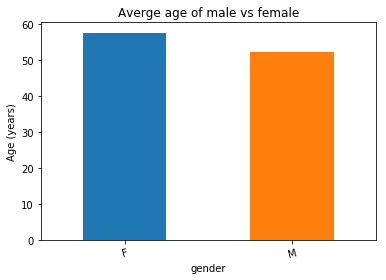

In [17]:
# Q1. Average age of male and female customers
av_age.plot.bar(rot=15, title='Averge age of male vs female')
plt.ylabel('Age (years)')


In [18]:
# Q2 Average income male vs female:
av_income = clean_profile.groupby(['gender']).mean()['income']
av_income

gender
F    71306.412139
M    61194.601603
Name: income, dtype: float64

Text(0,0.5,'Income')

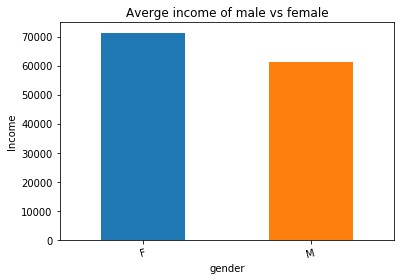

In [19]:
av_income.plot.bar(rot=15, title='Averge income of male vs female')
plt.ylabel('Income')


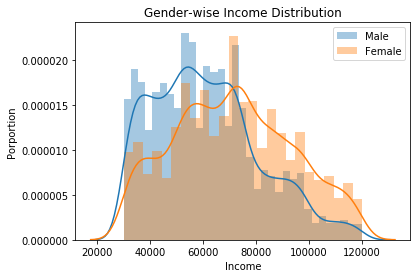

In [20]:
# Q3. Gender-wise Income Distribution
sns.distplot(clean_profile[clean_profile.gender=='M'].income,label='Male')
sns.distplot(clean_profile[clean_profile.gender=='F'].income,label='Female')
plt.xlabel("Income")
plt.ylabel("Porportion")
plt.title("Gender-wise Income Distribution") 
plt.legend()
plt.show()

Plot conclude that minimum and maximum income for both male and female are approximately same but the count of male customers in low-income level is slightly higher than that of female customers.

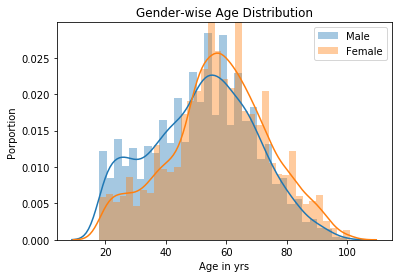

In [21]:
#Q4. Gender-wise age distribution
sns.distplot(clean_profile[clean_profile.gender=='M'].age,label='Male')
sns.distplot(clean_profile[clean_profile.gender=='F'].age,label='Female')
plt.xlabel("Age in yrs")
plt.ylabel("Porportion")
plt.title("Gender-wise Age Distribution") 
plt.legend()
plt.show()

The plot shows that gender wise distribution of age is qute similar. Majority of users are in age group of 40-60 years.


Q5. Compute what percent of customers enrolled in an year:

In [22]:
year_count = clean_profile['start_year'].value_counts()

year_count *= 100 / year_count.sum()
year_count

2017    37.706152
2018    24.731404
2016    20.474920
2015    10.730172
2014     4.502840
2013     1.854513
Name: start_year, dtype: float64

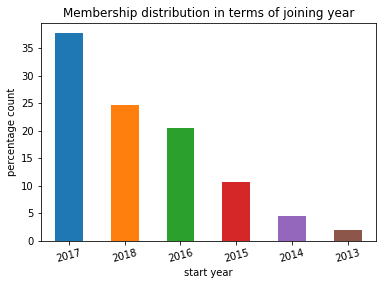

In [23]:
year_count.plot.bar(rot=15)
plt.xlabel('start year')
plt.ylabel('percentage count')
plt.title('Membership distribution in terms of joining year');

#The plot shows around 60% of customers have joined the starbucks reward program in 2017 and 2018.

Q6. What is the distribuion of male and female per year in the membership program?

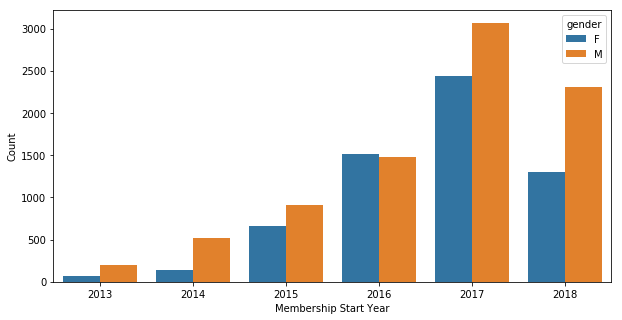

In [24]:
# groupby start_year and gender to plot a graph
membership_date = clean_profile.groupby(['start_year', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['start_year', 'gender', 'count']

# plot a bar graph for gender distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='start_year', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count');

1. The results suggest that most customers in the Starbucks rewards program are from 2017 followed by 2018. 
2. Plots also depict that there are more male customers joining the program every year.

In [25]:
gender_count = clean_profile.groupby(['gender']).count()['customer_id']
gender_count *= 100 / gender_count.sum()
gender_count

gender
F    41.942106
M    58.057894
Name: customer_id, dtype: float64

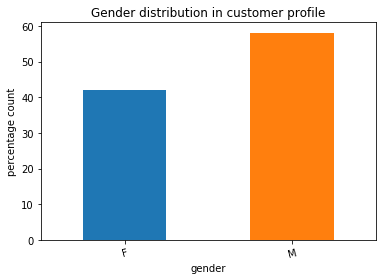

In [26]:
gender_count.plot.bar(rot=15)
plt.xlabel('gender')
plt.ylabel('percentage count')
plt.title('Gender distribution in customer profile');

3. The customer profile has 40% female and 60% males in total.

# Portfolio data

In [27]:
# preliminary EDA of Portfolio dataset shows the following:
print('1. The Portfolio data has {} rows and {} columns'.format(portfolio.shape[0], portfolio.shape[1]))
print('2. The Portfolio data is free of missing values.')
print('3. There are {} different types of offers disumbersed to customers by StarBucks'.format(portfolio.offer_id.nunique()))
print('4. There are 3 types of offers : BOGO, Discount and Informational which is further subcategorised based on difficulty and duration.')
print('5. There are 5 types of difficulty- 0,5,7,10,20 that offers are categorised into' )
print('6. The offers valid for 3,4,5,7 or 10 days')

1. The Portfolio data has 10 rows and 6 columns
2. The Portfolio data is free of missing values.
3. There are 10 different types of offers disumbersed to customers by StarBucks
4. There are 3 types of offers : BOGO, Discount and Informational which is further subcategorised based on difficulty and duration.
5. There are 5 types of difficulty- 0,5,7,10,20 that offers are categorised into
6. The offers valid for 3,4,5,7 or 10 days


In [28]:
portfolio

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [29]:
# Portfolio data set is free of missing values:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_id      10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


Q7. what are the different types of offers?

In [30]:
#Offers of each type
portfolio.groupby('offer_type')['offer_id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

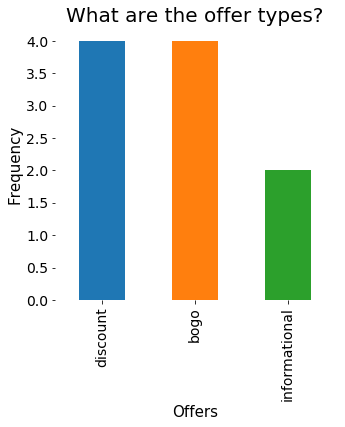

In [31]:
# a look at the different types of offers
ax = portfolio["offer_type"].value_counts().plot.bar(
    figsize=(5,5),
    fontsize=14,

)

ax.set_title("What are the offer types?", fontsize=20)
ax.set_xlabel("Offers", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

# Transcript Data

In [32]:
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [33]:
transcript.shape

(306534, 4)

In [34]:
# quick check on missing value
transcript.isnull().sum()

event          0
customer_id    0
time           0
value          0
dtype: int64

In [35]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

1. transcript dataframe is free of any mssing values.
2. It can be seen that there are 4 possible values: 'offer id', 'offer_id', 'reward' and 'amount', out of which 'offer id' and 'offer_id' are to be considered same.


In [36]:
# select one user and explore the transcript records
transcript[transcript['customer_id']=='0009655768c64bdeb2e877511632db8f']

,event,customer_id,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


# A look as how customers responds to offers

In [37]:
# how customer respond to offers--
response = 100*transcript.groupby('event').size()/transcript.shape[0]
response = response.reset_index()
response.columns = ['response', 'count']
response

,response,count
0,offer completed,10.954413
1,offer received,24.883700
2,offer viewed,18.831516
3,transaction,45.330371


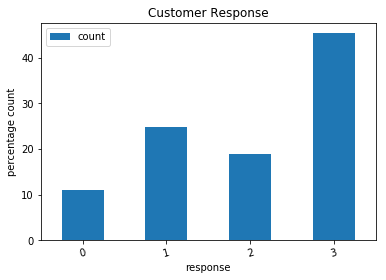

In [38]:
# plot a bar graph for customer response to offers
response.plot.bar(rot=15)
plt.xlabel('response')
plt.ylabel('percentage count')
plt.title('Customer Response');

In [39]:
def clean_transcript(transcript):
    '''
    INPUT:
    transcript - the transcript dataframe 
    
    OUTPUT:
    New columns are created from the value column:
    offer id , amount(money spent in "transaction")
    New column money_gained : money gained from "offer completed"
    Dropping value column
    
    '''
   
    # Functions to create offer_id and amount columns from the transcript table.
    clean_tran = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) or ('amount' in x)  else False)]
    clean_tran['offer_id'] = clean_tran['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else (x['offer_id'] if ('offer_id' in x)  else '0'))
    clean_tran['amount'] = clean_tran['value'].apply(lambda x: x['amount'] if ('amount' in x) else 0)
    clean_tran['money_cashback'] = clean_tran['value'].apply(lambda x: x.get('reward'))
    
    clean_tran.drop(columns=['value'], inplace=True)
    
    #replace nan
    clean_tran.fillna(0 , inplace=True)
    
    return clean_tran

In [40]:
clean_transcript = clean_transcript(transcript)

In [41]:
clean_transcript.shape

(306534, 6)

In [42]:
clean_transcript.head()

,event,customer_id,time,offer_id,amount,money_cashback
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [43]:
#check
clean_transcript[clean_transcript['customer_id']=='0009655768c64bdeb2e877511632db8f']

,event,customer_id,time,offer_id,amount,money_cashback
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
89291,transaction,0009655768c64bdeb2e877511632db8f,228,0,22.16,0.0
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,0.00,0.0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,0.00,0.0
153401,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
168412,transaction,0009655768c64bdeb2e877511632db8f,414,0,8.57,0.0
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
204340,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0


# Extract offer_data

We will make two dataframe from the clean_transcript data (306534 rows and 6 col) :
1. 'transcation df' - which have customers who have made purchases without being influenced by the offers. As for them offer_id == 0 and beleive that these customers are not influenced by the offers. (138953 instances)

2. 'offer df'- Here we have the set of customers who have recieved the offers and the will analyse the events that the customers have taken after they have recieved offers. We are interested in this set of data, as we will build a model later to understand how the customers have been influnced by an offer.(167581 instances)

In [44]:
# extract transactions from transcript data
transaction_df = clean_transcript[clean_transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event', 'money_cashback'], inplace=True)
transaction_df.head()



,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [45]:
transaction_df.shape

(138953, 3)

In [46]:
#number of customers who transact on starbucks without any influence of offers:
transaction_df.customer_id.nunique()

16578

In [47]:
# extract offer-related from transcript data
offer_df = clean_transcript[clean_transcript.event!='transaction'].copy()

offer_df.drop(columns=['amount'], inplace=True)

In [48]:
offer_df.shape

(167581, 5)

In [49]:
offer_df.head()

,event,customer_id,time,offer_id,money_cashback
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [50]:
offer_df.groupby('event').size()

event
offer completed    33579
offer received     76277
offer viewed       57725
dtype: int64

# Merge the offer_df, clean_portfolio and clean_profile data:

In [51]:
# Merge portfolio and offer_df into a df and call it offer_port:
offer_port = pd.merge(offer_df,portfolio, on=['offer_id'],how='left')

In [52]:
offer_port.head()

,event,customer_id,time,offer_id,money_cashback,channels,difficulty,duration,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,"[web, email, mobile]",5,7,bogo,5
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,"[web, email]",20,10,discount,5
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,"[web, email, mobile]",10,7,discount,2
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,"[web, email, mobile, social]",10,10,discount,2
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,"[web, email, mobile, social]",10,5,bogo,10


In [53]:
#merge offer_port with clean_profile df to get a final_df_2 df:
final_df = pd.merge(offer_port, clean_profile, on='customer_id')

In [54]:
final_df.shape

(146615, 16)

In [55]:
final_df.head()

,event,customer_id,time,offer_id,money_cashback,channels,difficulty,duration,offer_type,reward,age,gender,income,memberdays,start_year,start_month
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,"[web, email, mobile]",5,7,bogo,5,75.0,F,100000.0,1345,2017,5
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,"[web, email, mobile]",5,7,bogo,5,75.0,F,100000.0,1345,2017,5
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5,7,bogo,5,75.0,F,100000.0,1345,2017,5
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0,3,informational,0,75.0,F,100000.0,1345,2017,5
4,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0,3,informational,0,75.0,F,100000.0,1345,2017,5


Q8 How does customers responds(event) to different typesof offers?

In [56]:
offer_distribution = final_df.groupby(['offer_type','event']).size()
offer_distribution = offer_distribution.reset_index()
offer_distribution.columns = ['offer_type', 'event', 'count']

In [57]:
offer_distribution

,offer_type,event,count
0,bogo,offer completed,15013
1,bogo,offer received,26183
2,bogo,offer viewed,21724
3,discount,offer completed,16930
4,discount,offer received,26297
5,discount,offer viewed,18164
6,informational,offer received,13105
7,informational,offer viewed,9199


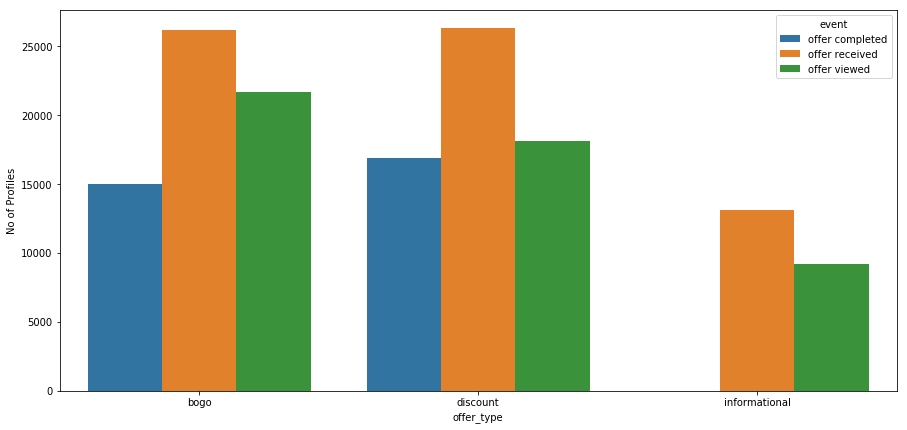

In [58]:
# plot offer_distribution
plt.figure(figsize=(15, 7))
sns.barplot(x='offer_type', y='count', hue='event', data=offer_distribution)
plt.xlabel('offer_type')
plt.ylabel('No of Profiles');

The above analysis show:
discount offera have a slightly better chance of getting completed.

In [59]:
offer_ids = final_df.groupby(['offer_id','event']).size()
offer_ids = offer_ids.reset_index()
offer_ids.columns = ['offer_id', 'event', 'count']
offer_ids

,offer_id,event,count
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed,3323
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,6627
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer viewed,2161
3,2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed,4819
4,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received,6563
5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,6289
6,2906b810c7d4411798c6938adc9daaa5,offer completed,3851
7,2906b810c7d4411798c6938adc9daaa5,offer received,6543
8,2906b810c7d4411798c6938adc9daaa5,offer viewed,3395
9,3f207df678b143eea3cee63160fa8bed,offer received,6561


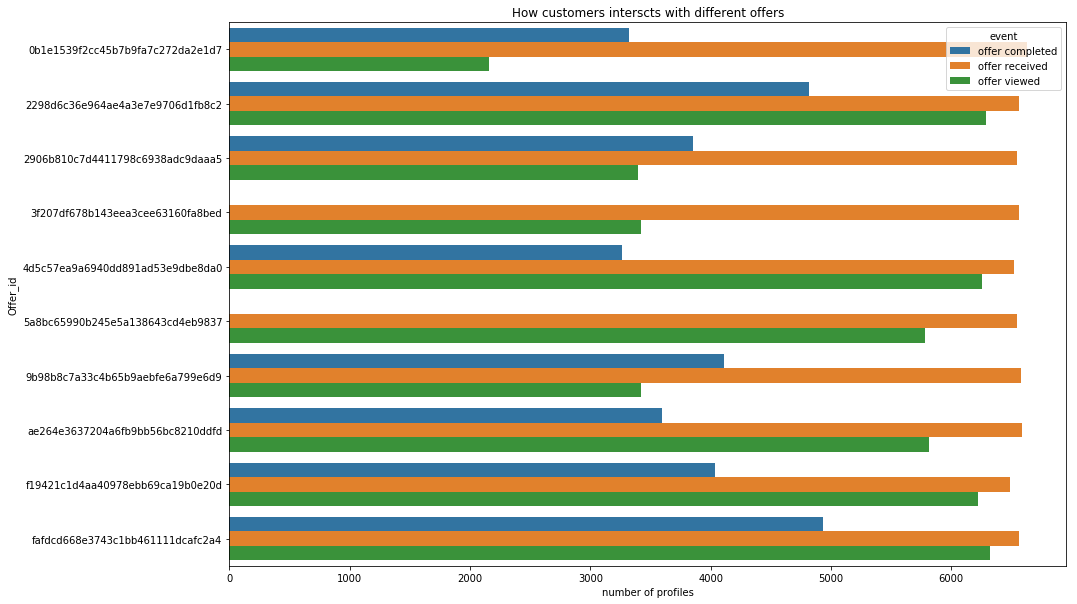

In [60]:
plt.figure(figsize=(15, 10))
sns.barplot(x='count', y='offer_id', hue='event', data=offer_ids)
plt.title('How customers interscts with different offers')
plt.ylabel('Offer_id')
plt.xlabel('number of profiles')

plt.show();

plot shows:
1.all the offers have been equally distributed in the customer pool.(have similar offer-recieved count)


Q9.How male and female respond to any offer?
a look at the distribution of gender in event and offer type.

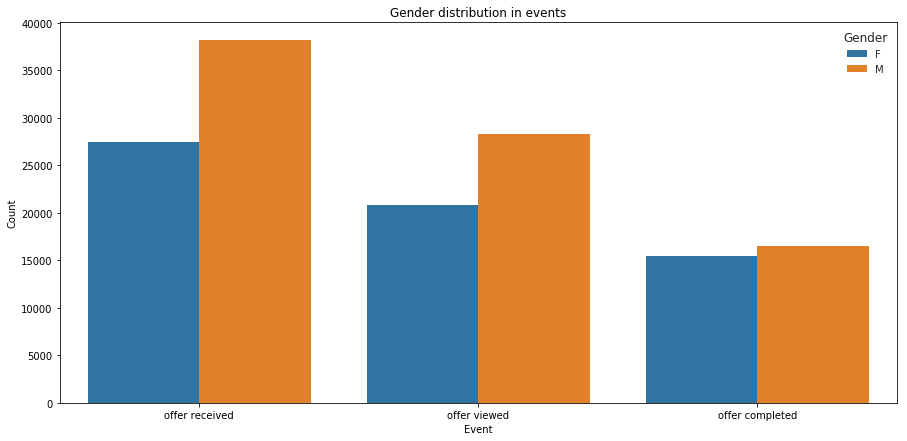

In [61]:
# gender distribution in events
plt.figure(figsize=(15, 7))
sns.countplot(x= "event", hue= "gender", data=final_df)
sns.set(style="darkgrid")
plt.title('Gender distribution in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

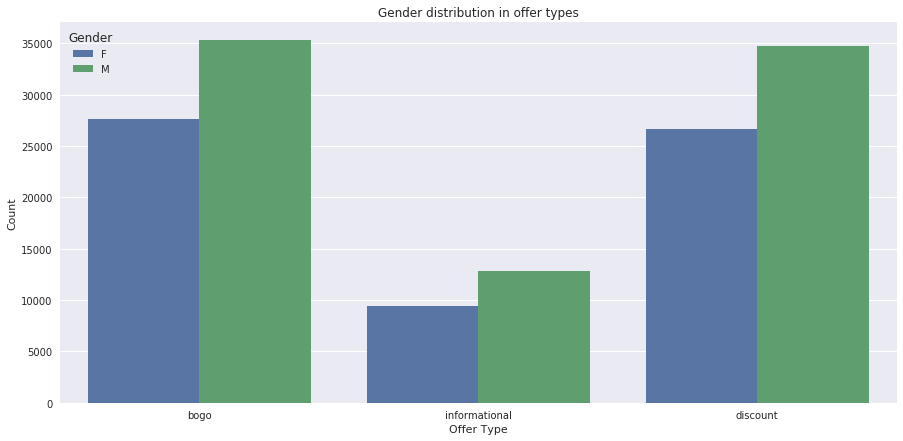

In [62]:
# gender distributio in offer type:
plt.figure(figsize=(15, 7))
sns.countplot(x= "offer_type", hue= "gender", data=final_df)
sns.set(style="darkgrid")
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')



plot shows that there is no significant difference in the distribution of types of offers across the gender.

# Data Preprocessing:


In [63]:
final = final_df.copy()


In [64]:
final.shape

(146615, 16)

In [65]:
#correletion matrix to find out which ctaegorical varables are not independent varibles:

corr = final.corr()
corr

,time,money_cashback,difficulty,duration,reward,age,income,memberdays,start_year,start_month
time,1.000000,0.095012,0.023153,0.025793,0.005491,0.006262,0.004360,0.005459,-0.006465,0.004827
money_cashback,0.095012,1.000000,0.139399,0.043203,0.288016,0.034679,0.081668,0.049067,-0.049031,0.007961
difficulty,0.023153,0.139399,1.000000,0.766392,0.421203,0.010461,0.026718,0.008618,-0.007584,-0.003182
duration,0.025793,0.043203,0.766392,1.000000,0.042469,0.007246,0.015635,0.014028,-0.012842,-0.002456
reward,0.005491,0.288016,0.421203,0.042469,1.000000,0.000821,0.014839,-0.000041,0.000372,-0.001754
age,0.006262,0.034679,0.010461,0.007246,0.000821,1.000000,0.306631,0.008214,-0.008831,0.004443
income,0.004360,0.081668,0.026718,0.015635,0.014839,0.306631,1.000000,0.017689,-0.021021,0.016443
memberdays,0.005459,0.049067,0.008618,0.014028,-0.000041,0.008214,0.017689,1.000000,-0.969222,0.041632
start_year,-0.006465,-0.049031,-0.007584,-0.012842,0.000372,-0.008831,-0.021021,-0.969222,1.000000,-0.285500
start_month,0.004827,0.007961,-0.003182,-0.002456,-0.001754,0.004443,0.016443,0.041632,-0.285500,1.000000


In [66]:
#Plot correlation matrix:
corr.style.background_gradient(cmap='coolwarm')


,time,money_cashback,difficulty,duration,reward,age,income,memberdays,start_year,start_month
time,1,0.0950116,0.0231527,0.0257927,0.00549106,0.0062616,0.00436021,0.00545866,-0.00646465,0.00482659
money_cashback,0.0950116,1,0.139399,0.0432029,0.288016,0.0346791,0.0816681,0.0490672,-0.0490309,0.0079608
difficulty,0.0231527,0.139399,1,0.766392,0.421203,0.0104614,0.0267182,0.00861762,-0.00758441,-0.00318162
duration,0.0257927,0.0432029,0.766392,1,0.0424685,0.00724635,0.0156353,0.0140283,-0.0128422,-0.00245608
reward,0.00549106,0.288016,0.421203,0.0424685,1,0.000820731,0.0148388,-4.12905e-05,0.000372071,-0.00175385
age,0.0062616,0.0346791,0.0104614,0.00724635,0.000820731,1,0.306631,0.00821439,-0.00883121,0.00444302
income,0.00436021,0.0816681,0.0267182,0.0156353,0.0148388,0.306631,1,0.0176887,-0.021021,0.0164431
memberdays,0.00545866,0.0490672,0.00861762,0.0140283,-4.12905e-05,0.00821439,0.0176887,1,-0.969222,0.0416325
start_year,-0.00646465,-0.0490309,-0.00758441,-0.0128422,0.000372071,-0.00883121,-0.021021,-0.969222,1,-0.2855
start_month,0.00482659,0.0079608,-0.00318162,-0.00245608,-0.00175385,0.00444302,0.0164431,0.0416325,-0.2855,1


The correlation matrix shows that 

1. The 'memberdays' and 'start_year ' shows a very strong negative correlation (-0.96). 
2. The 'duration' and 'difficulty' offer portfolio are highly correlated (0.766).
3. 'money_cashback' and 'reward' has some correlation(0.288).
4. Similarly 'reward' and 'difficulty' have a high correlation(0.42).

So we will drop duration, reward and columns. 
We will drop start_year and start_month and keep memeberdays. As they give simsilar info.


In [67]:
# Distribution of numeric variables- 'age', 'memberdays', start_year, start_month, time,  and 'income' 
def display_view_data():
    '''Display customer profile with distplot'''
    # Display Histogram of Customer Age
    user_age = sns.distplot(final['age'],fit=norm, bins = 20)
    user_age.set_title('Distribution of Customer Age')
    
    # Display Histogram of the days being member
    plt.show()
    memberdays = sns.distplot(final['memberdays'], fit=norm, bins = 50)
    memberdays.set_title('How long did the users become our members(days)')
    
    
    # Display Histogram of start_month
    plt.show()
    user_income = sns.distplot(final['start_month'], fit=norm, bins = 20)
    user_income.set_title('Distribution of Customer joining month')
    
    # Display Histogram of start_year
    plt.show()
    user_income = sns.distplot(final['start_year'], fit=norm, bins = 20)
    user_income.set_title('Distribution of Customer joining year')
    
    
    # Display Histogram of User Income
    plt.show()
    user_income = sns.distplot(final['income'], fit=norm, bins = 20)
    user_income.set_title('Distribution of Customer Income')
    

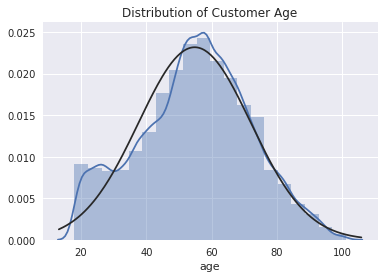

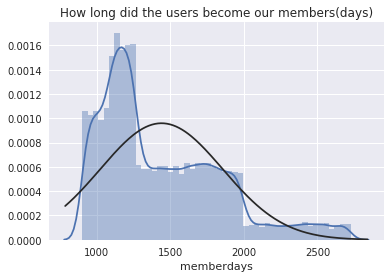

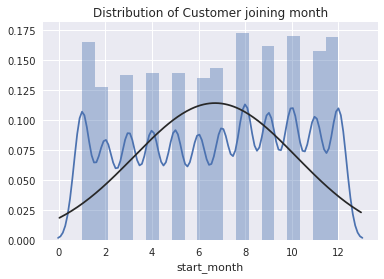

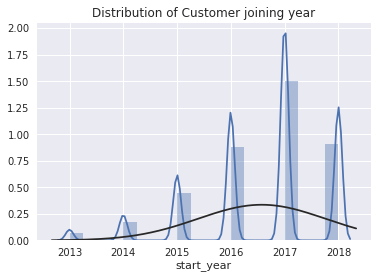

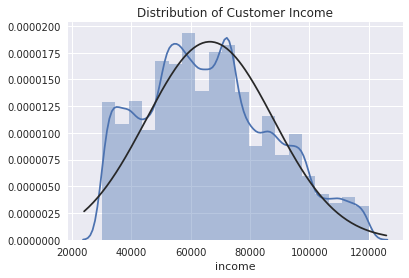

In [68]:
display_view_data()

Analyses of the distribution curves shows:
1. 'age' shows a normal distribution. And peak around 50 years, most members aappear to be in the age group of 40-60 years.
2. 'member_days' has a right skewed curve, showing that most members on the app are from last 3 years(approx 1000 days).
3. Income distribution is not a normal distibution .
4. Majority of Starbucks users have become member in 2017 followed by 2018.
5. Also the joining start_month plot shows that month has no significant impact on joining a membership program. we will drop it too.

In [69]:
#colummn to be dropped 
final.drop(['customer_id','duration', 'reward','start_year', 'start_month', 'offer_id'], axis=1, inplace=True)


# Building a ML model to predict customer response:
Model: we will build a Machine Learning model to predict response of a customer to an offer who have recieved the offer. Reponse will be in the form of whether he:
1. recieved an offer [offer_recieved: 1
2. view an offer ['offer viewed':2]
3. complete an offer ['offer completed':3]


We will use the 'final' df to train on three classifiers:
1. KNN
2. Random Forest
3. Descion Tree

We will train KNN , Random Forest, Descion Tree classifiers on the training data.

Metrics: We will consider the F1 score as the model metric to assess the quality of the approach and determine which model gives the best results. It can be interpreted as the weighted average of the precision and recall. The traditional or balanced F-score (F1 score) is the harmonic mean of precision and recall, where an F1 score reaches its best value at 100 and worst at 0.

In [71]:
final.head()

,event,time,money_cashback,channels,difficulty,offer_type,age,gender,income,memberdays
0,offer received,0,0.0,"[web, email, mobile]",5,bogo,75.0,F,100000.0,1345
1,offer viewed,6,0.0,"[web, email, mobile]",5,bogo,75.0,F,100000.0,1345
2,offer completed,132,5.0,"[web, email, mobile]",5,bogo,75.0,F,100000.0,1345
3,offer received,168,0.0,"[email, mobile, social]",0,informational,75.0,F,100000.0,1345
4,offer viewed,216,0.0,"[email, mobile, social]",0,informational,75.0,F,100000.0,1345


In [72]:
def preprocess_data(df):
    """
    Clean merged data frame for the final data as per tasks 1-5.
    
    Parameters
    ----------
    df: input data frame
    
    Returns
    -------
    df: cleaned data frame as per tasks
       
    """
    #process categorical variables
    categorical = ['gender','offer_type']
    df = pd.get_dummies(df, columns = categorical)
    
    #process channels column 
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    
    #encode 'event' data to numerical values according to task 2
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    
    return df
    
    

In [74]:
preprocess_data = preprocess_data(final)

In [75]:
preprocess_data.head()

,event,time,money_cashback,difficulty,age,income,memberdays,gender_F,gender_M,offer_type_bogo,offer_type_discount,offer_type_informational,email,mobile,social,web
0,1,0,0.0,5,75.0,100000.0,1345,1,0,1,0,0,1,1,0,1
1,2,6,0.0,5,75.0,100000.0,1345,1,0,1,0,0,1,1,0,1
2,3,132,5.0,5,75.0,100000.0,1345,1,0,1,0,0,1,1,0,1
3,1,168,0.0,0,75.0,100000.0,1345,1,0,0,0,1,1,1,1,0
4,2,216,0.0,0,75.0,100000.0,1345,1,0,0,0,1,1,1,1,0


In [76]:
# We will split the preprocess_df into:
label = preprocess_data['event']
data = preprocess_data.drop('event', axis=1)   


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146615 entries, 0 to 146614
Data columns (total 15 columns):
time                        146615 non-null int64
money_cashback              146615 non-null float64
difficulty                  146615 non-null int64
age                         146615 non-null float64
income                      146615 non-null float64
memberdays                  146615 non-null int64
gender_F                    146615 non-null uint8
gender_M                    146615 non-null uint8
offer_type_bogo             146615 non-null uint8
offer_type_discount         146615 non-null uint8
offer_type_informational    146615 non-null uint8
email                       146615 non-null int64
mobile                      146615 non-null int64
social                      146615 non-null int64
web                         146615 non-null int64
dtypes: float64(3), int64(7), uint8(5)
memory usage: 18.0 MB


In [78]:
#feature scaling of data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sc = StandardScaler()
data = sc.fit_transform(data)

In [79]:
#split the data into train and test sets:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size = 0.3, random_state = 0)

print("Training set: {} rows".format(x_train.shape[0]))
print("Testing set: {} rows".format(x_test.shape[0]))
    

Training set: 102630 rows
Testing set: 43985 rows


In [80]:
def train_test(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_prediction =  (clf.fit(x_train, y_train)).predict(x_train)
    test_predictions = clf.predict(x_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

ClfA - KNeighborsClassifier (Benchmark)

We use the K-Nearest Neighbors algorithm to build the benchmark, and evaluate the model result by the F1 score metric.

In [81]:
clf_A = KNeighborsClassifier(n_neighbors = 5)
a_train_f1, a_test_f1, a_model = train_test(clf_A)

In [82]:
knn = {'Benchmark Model': [ a_model], 'train F1 score':[a_train_f1], 'test F1 score': [a_test_f1]}
benchmark = pd.DataFrame(knn)


In [83]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,75.325928,58.185745


Clf B - Random Forest Classifier



In [84]:
clf_B = RandomForestClassifier(random_state = 10)
b_train_f1, b_test_f1, b_model = train_test(clf_B)

Clf_C - Decision Tree

In [85]:
clf_C = DecisionTreeClassifier(random_state = 10)
c_train_f1, c_test_f1, c_model = train_test(clf_C)

Model comparisons:

In [86]:
models = {'Model': ['KNeighborsClassifier (Benchmark)', b_model, c_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1] }
          
comp = pd.DataFrame(models)

In [87]:
comp

,Model,train F1 score,test F1 score
0,KNeighborsClassifier (Benchmark),75.325928,58.185745
1,RandomForestClassifier,94.174218,74.270774
2,DecisionTreeClassifier,94.939102,85.574628


Conclusion:

Right now the perfoarmance of the Descion Tree model is quite satisfactory. 

New models need to be tested, one appraoch will be to make an ANN model.